In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### How to implement a Kalman Filter / Particle Filter? 

## Discrete-Time 2D Point Mass Moving Task

We consider a simple discrete-time 2D point mass moving task without considering dynamics. The state of the point mass is defined as the concatenation of its position and velocity:

$$
x_t = \begin{pmatrix} p_t \\ v_t \end{pmatrix}
$$

The control input is the change in velocity, denoted as \(u_t\). The motion model can be described as:

$$
x_{t+1} = A x_t + B u_t + w_t
$$

where:

$$
A = 
\begin{pmatrix} 
I & dt \cdot I \\ 
0 & I 
\end{pmatrix}, \quad
B = 
\begin{pmatrix} 
0 \\ 
I 
\end{pmatrix}, \quad
w_t \sim \mathcal{N}(0, K)
$$

---

### Measurement Tools and Observation Models

We assume two measurement tools are available:

1. **Direct Position Measurement**: A depth camera directly measures the position of the point mass, but with high noise. The observation model is:

$$
y_t = C x_t + {q}_t
$$

where:

$$
C = 
\begin{pmatrix} 
I & 0 
\end{pmatrix}, \quad
q_t \sim \mathcal{N}(0, Q)
$$

2. **Landmark-Based Measurement**: A lidar sensor provides measurements of the distance to two fixed landmarks, \(l_1\) and \(l_2\). The observation model is:

$$
y_t = 
\begin{pmatrix} 
\|p_t - l_1\|_2 \\ 
\|p_t - l_2\|_2 
\end{pmatrix} + r_t
$$

where:

$$
r_t \sim \mathcal{N}(0, R)
$$

---

### Noise Properties

- \(Q\) and \(R\) are positive definite covariance matrices corresponding to the white noise $q_t$ and $r_t$, respectively.
- Due to our assumptions about the equipment, \(Q - R > 0\).


In [50]:
class PointMass2D:
    def __init__(self, init_state, control_trajectory, dt, landmarks, K, Q, R):
        """
        Parameters:
        - init_state: np.array (4,) [p_x, p_y, v_x, v_y]
        - control_trajectory: np.array (N, 2) [delta_v_x, delta_v_y] over time
        - dt: float, time step
        - landmarks: np.array (2, 2) [l1, l2], positions of the landmarks
        - K: np.array (4, 4), covariance matrix for motion noise
        - Q: np.array (2, 2), covariance matrix for camera noise
        - R: np.array (2, 2), covariance matrix for lidar noise
        """
        self.dt = dt
        self.landmarks = landmarks
        self.K = K
        self.Q = Q
        self.R = R

        # State transition matrices
        self.A = np.block([[np.eye(2), dt * np.eye(2)], [np.zeros((2, 2)), np.eye(2)]])
        self.B = np.block([[np.zeros((2, 2))], [np.eye(2)]])

        # Generate ground truth trajectory
        self.ground_truth = [init_state]
        for u in control_trajectory:
            next_state = self.A @ self.ground_truth[-1] + self.B @ u
            self.ground_truth.append(next_state)
        self.ground_truth = np.array(self.ground_truth)

    def step(self, current_state, control_input, use_camera=True):
        """
        Perform a single step in the simulation.
        
        Parameters:
        - current_state: np.array (4,)
        - control_input: np.array (2,) [delta_v_x, delta_v_y]
        - use_camera: bool, whether to use the camera or lidar+landmarks for observation

        Returns:
        - next_state: np.array (4,), next true state
        - observation: np.array, depends on the observation model
        """
        # Update state with kinematics
        process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=self.K)
        next_state = self.A @ current_state + self.B @ control_input + process_noise
        
        # Generate observation
        if use_camera:
            noise = np.random.multivariate_normal(mean=np.zeros(2), cov=self.Q)
            observation = next_state[:2] + noise
        else:
            distances = np.linalg.norm(next_state[:2] - self.landmarks, axis=1)
            noise = np.random.multivariate_normal(mean=np.zeros(2), cov=self.R)
            observation = distances + noise

        return next_state, observation
    
    def camera_measurement(self, particles, measurement):
        """
        Compute the measurement values and likelihoods for particles using the camera model.
        
        Parameters:
        - particles: np.array (N, 4), a batch of particles
        - measurement: np.array (2,) the measurement of the camera model
        
        Returns:
        - likelihoods: np.array (N,), likelihoods for each particle
        """
        # Extract positions from particles
        positions = particles[:, :2]  # (N, 2)
        diffs = measurement[None, :] - positions # (N,2)
        
        # Compute likelihoods based on noise model
        likelihoods = np.exp(-0.5 * np.einsum("bi,ij,bj->b", diffs, np.linalg.inv(self.Q), diffs)) # (N,)
        likelihoods /= np.sqrt((2 * np.pi) ** 2 * np.linalg.det(self.Q)) # (N,)
        
        return likelihoods

    def landmark_measurement(self, particles, measurement):
        """
        Compute the measurement values and likelihoods for particles using the landmark model.
        
        Parameters:
        - particles: np.array (N, 4), a batch of particles
        - measurement: np.array (2,) the measurement of the landmark model
        
        Returns:
        - measurements: np.array (N, 2), simulated lidar measurements (distances to landmarks)
        - likelihoods: np.array (N,), likelihoods for each particle
        """
        # Extract positions from particles
        positions = particles[:, :2]  # (N, 2)
        
        # Compute distances to each landmark
        particle2Landmarks = np.linalg.norm(positions[:, None, :] - self.landmarks[None, :, :], axis=-1)  # (N, 2)
        
        # Generate likelihoods based on noise model
        diffs = particle2Landmarks - measurement[None,:]  # (N, 2)
        likelihoods = np.exp(-0.5 * np.einsum("bi,ij,bj->b", diffs, np.linalg.inv(self.R), diffs)) # (N,)
        likelihoods /= np.sqrt((2 * np.pi) ** 2 * np.linalg.det(self.R))
        
        return likelihoods


def visualize(init_state, trajectory, landmarks):
    """
    Visualize the trajectory and landmarks.

    Parameters:
    - init_state: np.array (4,) [p_x, p_y, v_x, v_y], initial state
    - trajectory: np.array (N, 4), sequence of states
    - landmarks: np.array (2, 2), positions of landmarks
    """
    plt.figure(figsize=(8, 6))

    # Plot the trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], label="Trajectory", linestyle='-', linewidth=2)

    # Plot the initial position
    plt.scatter(init_state[0], init_state[1], color='red', label="Initial Position", zorder=5)

    # Plot the landmarks
    plt.scatter(landmarks[:, 0], landmarks[:, 1], color='green', label="Landmarks", zorder=5)
    for i, lm in enumerate(landmarks):
        plt.text(lm[0], lm[1], f"L{i+1}", fontsize=10, color='green', ha='right')

    plt.title("2D Point Mass Trajectory and Landmarks", fontsize=14)
    plt.xlabel("X Position", fontsize=12)
    plt.ylabel("Y Position", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


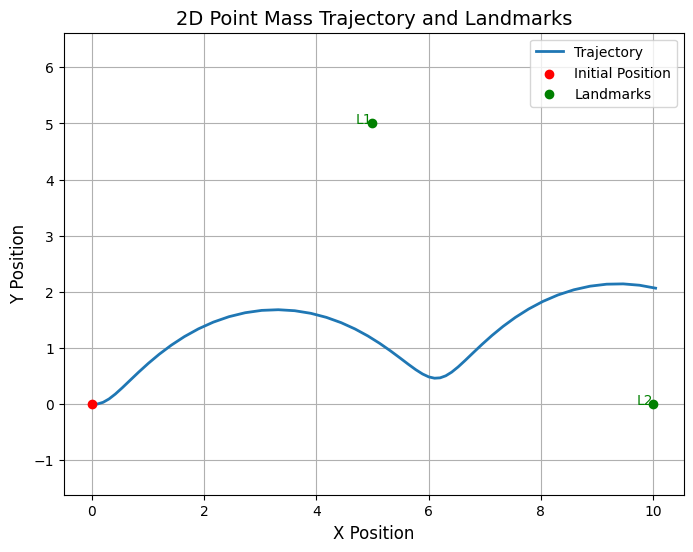

In [51]:
init_state = np.array([0.0, 0.0, 1.0, 0.0])
control_trajectory = np.concatenate([0.2*np.sin(np.linspace(0,10,50))[:,None], 0.3*np.cos(np.linspace(0,10,50))[:,None]], axis=1) #np.array([[0.1, 0.11]] * 50)
dt = 0.1 
landmarks = np.array([[5.0, 5.0], [10.0, 0.0]])
K = np.diag([1e-8, 1e-8, 0.01, 0.01])
Q = np.array([[0.1, -0.01],[-0.01, 0.1]])
R = np.diag([0.01, 0.01])

env = PointMass2D(init_state, control_trajectory, dt, landmarks, K, Q, R)

current_state = init_state
control_input = np.array([0.1, 0.0])
next_state, observation = env.step(current_state, control_input, use_camera=True)

visualize(init_state, env.ground_truth, landmarks)

## Bayesian Filtering and Kalman Filter (KF)

In real-world scenarios, we can never directly access the true state of a target object. Instead, we must infer the state based on observations and control inputs. The **Bayes filter** provides a probabilistic framework for this purpose, expressed as:

$$
p(x_k | x_0, v_{1:k}, y_{0:k}) = \eta \cdot p(y_k | x_k) \int p(x_k | x_{k-1}, v_k) p(x_{k-1} | x_0, v_{1:k-1}, y_{0:k-1}) dx_{k-1}
$$

where the integral can be interpreted as an expectation:

$$
p(x_k | x_0, v_{1:k}, y_{0:k}) = \eta \cdot p(y_k | x_k) \mathbb{E}_{p(x_{k-1} | x_0, v_{1:k-1}, y_{0:k-1})} \left[ p(x_k | x_{k-1}, v_k) \right]
$$

---

### Gaussian Assumption and Linear Models

If we assume:
- The belief $p(x_k | \cdot)$ is Gaussian, and
- The motion and observation models are linear,

then this update has a closed-form solution, which is implemented as the **Kalman Filter (KF)**. 

For non-linear models, the integral must be approximated:
- **Monte Carlo (MC)** methods numerically estimate the integral.
- **Extended Kalman Filter (EKF)** approximates motion/measurement models linearly.
- **Sigma-Point Kalman Filter (SPKF)** (e.g., Unscented KF) combines sampling and linearization.

---

### Kalman Filter Implementation

The derivation of the KF can be achieved through multiple approaches, including:
- **Maximum-Aposterior (MAP) estimation**,
- **Full Bayesian inference**, and
- **Gain optimization**.

All approaches arrive at the same solution under the Gaussian assumption, where the mode coincides with the mean.

Here, we focus on the implementation of the **Kalman Filter** for time-invariant systems.

#### Prediction Step

$$
\tilde{P}_k = A P_{k-1} A^T + K
$$

$$
\tilde{x}_k = A x_{k-1} + B u_{k-1}
$$

#### Kalman Gain

$$
G_k = \tilde{P}_k C^T (C \tilde{P}_k C^T + Q )^{-1}
$$

$$
P_k = (I - G_k C) \tilde{P}_k
$$

#### Correction Step

$$
x_k = \tilde{x}_k + G_k (y_k - C \tilde{x}_k)
$$
The $\tilde{\cdot}$ means the random variable is not corrected by the measurement.

---

### Summary

The Kalman Filter iteratively updates the state estimate ($x_k$) and its uncertainty ($P_k$) based on:
1. **Prediction**: Evolving the state forward using the motion model.
2. **Correction**: Adjusting the predicted state with new measurements.

This process ensures an optimal state estimate for linear systems under Gaussian noise assumptions.


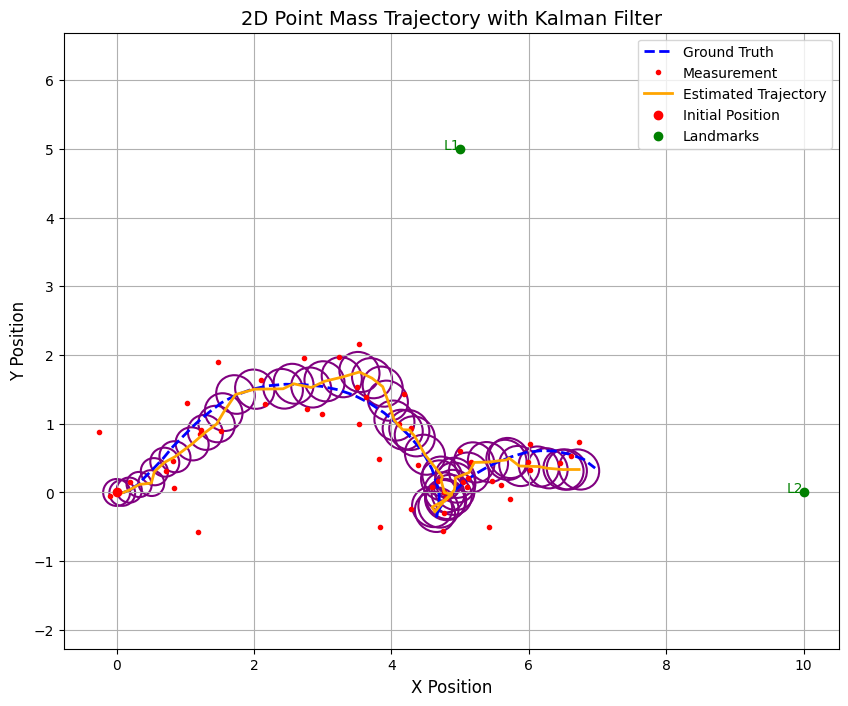

In [52]:
def kalman_filter_camera(env, control_trajectory, observations):
    """
    Apply Kalman Filter using camera observations.
    
    Parameters:
    - env: PointMass2D, the environment
    - control_trajectory: np.array (N, 2), control inputs over time
    - observations: np.array (N, 2), camera observations over time
    
    Returns:
    - estimated_states: np.array (N, 4), estimated state means over time
    - estimated_covariances: list of np.array (4, 4), estimated state covariances over time
    """
    A = env.A
    B = env.B
    C = np.block([[np.eye(2), np.zeros((2, 2))]])  # Observation matrix
    Q = env.Q  # Camera noise covariance
    K = env.K  # Motion noise covariance

    # Initialize state and covariance
    x_k = env.ground_truth[0]  # Initial state
    P_k = 0.01*np.eye(4)  # Initial covariance (identity for simplicity)

    estimated_states = [x_k]
    estimated_covariances = [P_k]

    for i, u_k in enumerate(control_trajectory):
        # Prediction step
        x_k_pred = A @ x_k + B @ u_k
        P_k_pred = A @ P_k @ A.T + K

        # Update step (correction)
        y_k = observations[i]
        G_k = P_k_pred @ C.T @ np.linalg.inv(C @ P_k_pred @ C.T + Q)
        x_k = x_k_pred + G_k @ (y_k - C @ x_k_pred)
        P_k = (np.eye(4) - G_k @ C) @ P_k_pred

        # Store results
        estimated_states.append(x_k)
        estimated_covariances.append(P_k)

    return np.array(estimated_states), estimated_covariances


def visualize_with_ellipse(init_state, trajectory, measurements, landmarks, estimated_states, estimated_covariances):
    """
    Visualize the ground truth trajectory, estimated trajectory, landmarks, and uncertainty ellipses.
    
    Parameters:
    - init_state: np.array (4,) [p_x, p_y, v_x, v_y], initial state
    - trajectory: np.array (N, 4), ground truth trajectory
    - landmarks: np.array (2, 2), positions of landmarks
    - estimated_states: np.array (N, 4), estimated state means
    - estimated_covariances: list of np.array (4, 4), estimated state covariances
    """
    plt.figure(figsize=(10, 8))

    # Plot the ground truth trajectory
    plt.plot(trajectory[:, 0], trajectory[:, 1], label="Ground Truth", linestyle='--', color='blue', linewidth=2)
    if isinstance(measurements, np.ndarray):
        plt.plot(measurements[:, 0], measurements[:, 1], 'r.', label="Measurement", linewidth=2)

    # Plot the estimated trajectory
    estimated_positions = estimated_states[:, :2]
    plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], label="Estimated Trajectory", linestyle='-', color='orange', linewidth=2)

    # Plot the initial position
    plt.scatter(init_state[0], init_state[1], color='red', label="Initial Position", zorder=5)

    # Plot the landmarks
    plt.scatter(landmarks[:, 0], landmarks[:, 1], color='green', label="Landmarks", zorder=5)
    for i, lm in enumerate(landmarks):
        plt.text(lm[0], lm[1], f"L{i+1}", fontsize=10, color='green', ha='right')

    # Plot uncertainty ellipses
    for i, (mean, cov) in enumerate(zip(estimated_positions, estimated_covariances)):
        eigvals, eigvecs = np.linalg.eigh(cov[:2, :2])
        angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
        angle = np.degrees(angle)
        width, height = 1.96 * 2 * np.sqrt(eigvals)  # 1-sigma ellipse
        ellipse = patches.Ellipse(xy=mean, width=width, height=height, angle=angle, 
                                    edgecolor='purple', facecolor='none', lw=1.5)
        plt.gca().add_patch(ellipse)

    plt.title("2D Point Mass Trajectory with Kalman Filter", fontsize=14)
    plt.xlabel("X Position", fontsize=12)
    plt.ylabel("Y Position", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Generate camera observations (with noise)
observations = []
hidden_states = []
current_state = init_state
hidden_states.append(current_state.copy())
for u in control_trajectory:
    current_state, observation = env.step(current_state, u, use_camera=True)
    observations.append(observation)
    hidden_states.append(current_state.copy())

observations = np.array(observations)
hidden_states = np.array(hidden_states)

# Apply Kalman Filter
estimated_states, estimated_covariances = kalman_filter_camera(env, control_trajectory, observations)

# Visualize results
visualize_with_ellipse(init_state, hidden_states, observations, landmarks, estimated_states, estimated_covariances)


Text(0, 0.5, 'velocity each axis')

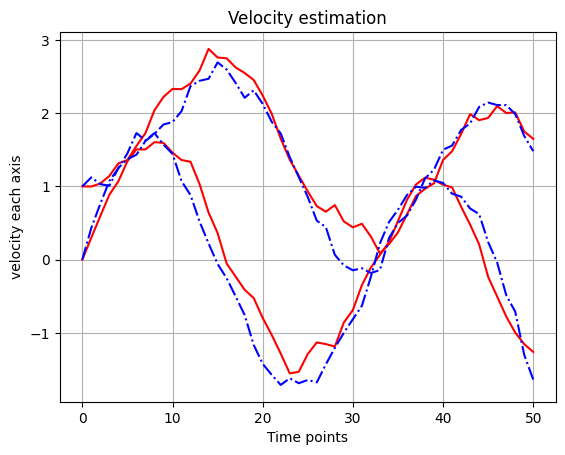

In [53]:
plt.title("Velocity estimation")
plt.plot(estimated_states[:,2:], 'r-')
plt.plot(hidden_states[:,2:], 'b-.')
plt.grid()
plt.xlabel("Time points")
plt.ylabel("velocity each axis")

I would say this approach is usable in most robotics applications, as dynamics are often not explicitly considered. However, if we have sensors with higher accuracy but nonlinear observation models, it is worth exploring alternative observer design methods to improve estimation accuracy. 

In such cases, the Kalman Filter (KF) alone is insufficient. Typically, the following methods are used:
- **Extended Kalman Filter (EKF)** or **Iterated EKF**: For approximating nonlinear systems linearly.
- **Sigma-point Kalman Filter**: For better approximation of nonlinear systems with "sigma-point transformation", but assume the belief state is Gaussian.
- **Particle Filter (PF)**: For handling non-Gaussian, nonlinear observation models.

From our experience, it’s challenging to predict which method will yield the best accuracy without implementing and testing them. If you are interested in EKF, you could check the [material from last year](https://colab.research.google.com/drive/1hoF0OmroE8ijXmJHbTiABBDl3VYh8sC0?usp=sharing). However, there is increasingly popurlar in particle filter as it is one of the only practical methods to handle non-Gaussian non-linear observation model. Let's explore how it will improve the filtering performance.

### Particle Filter and Bayesian Filter Expectation Representation

Recall the expectation representation of the Bayesian filter:

$$
p(x_k | x_0, v_{1:k}, y_{0:k}) = \eta \cdot p(y_k | x_k) \mathbb{E}_{p(x_{k-1} | x_0, v_{1:k-1}, y_{0:k-1})} \left[ p(x_k | x_{k-1}, v_k) \right]
$$

The main idea of the **Particle Filter** is to represent the belief distribution as a set of particles. Specifically:

- The term 
  $$ 
  \mathbb{E}_{p(x_{k-1} | x_0, v_{1:k-1}, y_{0:k-1})} \left[ p(x_k | x_{k-1}, v_k) \right]
  $$
  is approximated by passing the particles from the previous belief state $p(x_{k-1} | x_0, v_{1:k-1}, y_{0:k-1})$ through the (possibly nonlinear) system dynamics $p(x_k | x_{k-1}, v_k)$, including process noise (diffusion).

- The **posterior distribution** is then proportional to the product of the measurement likelihood $p(y_k | x_k)$ and the expectation term, which becomes a function of $p(x_k)$.

- The diffused particles represent the density of $p(x_k)$. By multiplying each particle's weight with the likelihood score $p(y_k | x_k)$, followed by normalization and resampling, the new set of particles will represent the posterior belief $p(x_k | x_0, v_{1:k}, y_{0:k})$.



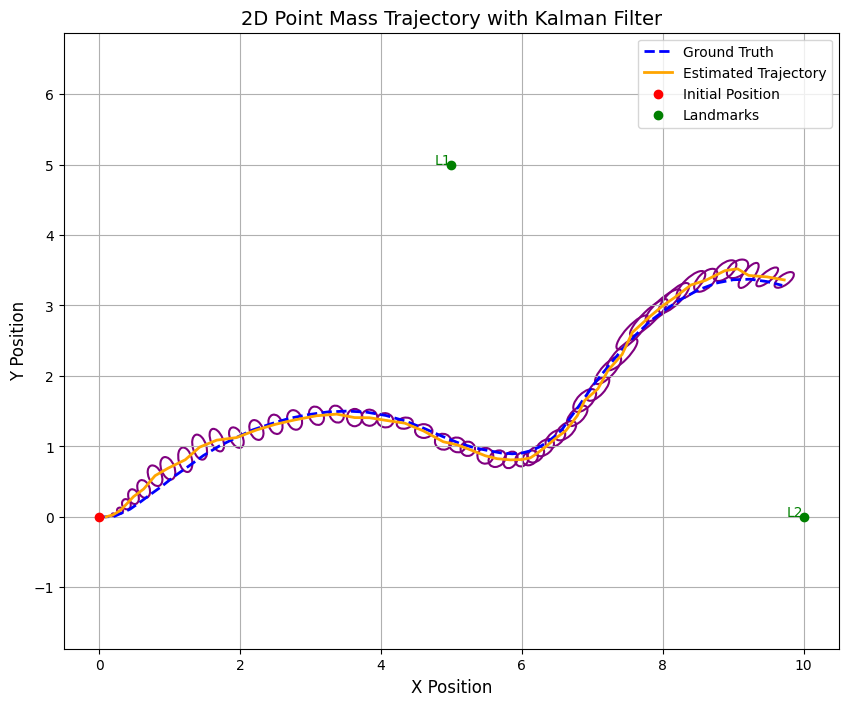

In [54]:
class ParticleFilter:
    def __init__(self, num_particles, init_state, motion_model, env):
        """
        Initialize the Particle Filter.

        Parameters:
        - num_particles: int, number of particles
        - init_state: np.array (4,), initial state [p_x, p_y, v_x, v_y]
        - motion_model: function, motion model f(x_k-1, u_k)
        - env: PointMass2D, environment with observation and likelihood models
        """
        self.num_particles = num_particles
        self.particles = np.tile(init_state, (num_particles, 1))  # Initialize particles
        self.weights = np.ones(num_particles) / num_particles  # Uniform weights
        self.motion_model = motion_model
        self.env = env

    def predict(self, control_input):
        """
        Predict step: propagate particles through the motion model.

        Parameters:
        - control_input: np.array (2,), control input [delta_v_x, delta_v_y]
        """
        for i in range(self.num_particles):
            process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=self.env.K)
            self.particles[i] = self.motion_model(self.particles[i], control_input) + process_noise

    def update(self, measurement):
        """
        Update step: compute particle weights based on the landmark observation model.

        Parameters:
        - measurement: np.array (2,), distances to landmarks
        """
        likelihoods = self.env.landmark_measurement(self.particles, measurement)
        
        # Update weights
        self.weights *= likelihoods
        self.weights += 1e-16  # Avoid division by zero
        self.weights /= np.sum(self.weights)  # Normalize weights

    def resample(self):
        """
        Resample particles based on their weights (systematic resampling).
        """
        indices = np.zeros(self.num_particles, dtype=int)
        cumulative_sum = np.cumsum(self.weights)
        cumulative_sum[-1] = 1.0  # Avoid round-off errors
        step = 1.0 / self.num_particles
        r = np.random.uniform(0, step)
        j = 0

        for i in range(self.num_particles):
            u = r + i * step
            while u > cumulative_sum[j]:
                j += 1
            indices[i] = j

        # Resample particles and reset weights
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        """
        Estimate the state as the weighted mean of the particles.

        Returns:
        - mean: np.array (4,), the estimated state
        - covariance: np.array (4, 4), the estimated covariance
        """
        mean = np.average(self.particles, weights=self.weights, axis=0)
        diffs = self.particles - mean
        covariance = np.dot(self.weights * diffs.T, diffs)
        return mean, covariance


# Particle Filter Implementation Example with Landmarks
num_particles = 500
pf = ParticleFilter(num_particles, init_state, lambda x, u: env.A @ x + env.B @ u, env)

estimates = []
covariances = []
hidden_states = []
# Simulate particle filter
current_state = init_state
hidden_states.append(current_state.copy())
for t, control_input in enumerate(control_trajectory):
    # Simulate the actual system to generate noisy landmark measurements
    current_state, observation = env.step(current_state, control_input, use_camera=False)

    hidden_states.append(current_state.copy())
    # Predict step
    pf.predict(control_input)

    # Update step with landmark observations
    pf.update(observation)

    # Resample
    pf.resample()

    # Estimate state
    mean, covariance = pf.estimate()
    estimates.append(mean)
    covariances.append(covariance)

# Convert results to arrays for visualization
estimates = np.array(estimates)
real_states = np.array(hidden_states)

# Visualize results
visualize_with_ellipse(init_state, real_states, None, landmarks, estimates, covariances)


Text(0, 0.5, 'velocity each axis')

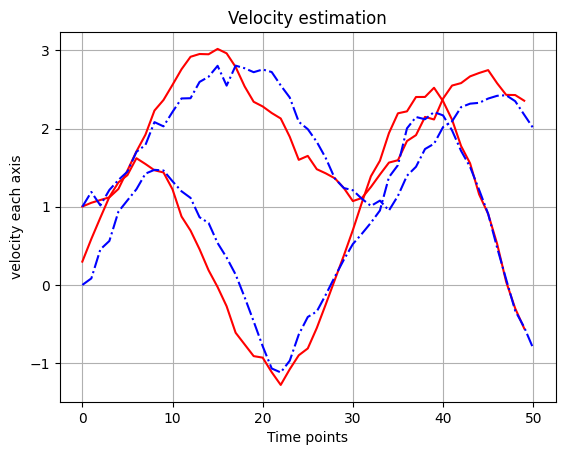

In [55]:
plt.title("Velocity estimation")
plt.plot(estimates[:,2:], 'r-')
plt.plot(real_states[:,2:], 'b-.')
plt.grid()
plt.xlabel("Time points")
plt.ylabel("velocity each axis")

For those who is familiar with Bayesian inference, incorporating additional sensors into the measurement likelihood is straightforward. This enables seamless **multi-sensory fusion**. Thank you!
